In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
from itertools import product

In [2]:
def E(data,w, theta):
    #d: NrofSpins
    #w.shape: (d,d)
    #theta.shape: (d,)
    #data: (N,d)
    d = w.shape[0]
    correlations = np.sum(np.multiply((data@((1-np.eye(d))*w)), data), axis = 1)/2
    local_field = data@theta

    return -(correlations + local_field)

def E_indep(data, w, theta):
    #d: NrofSpins
    #w.shape: (d,d)
    #theta.shape: (d,)
    #data: (N,d)
    local_field = data@theta

    return -local_field

def p_star(data,w,theta, Energy_functional = E):
    return np.exp(-Energy_functional(data,w,theta))

def p(data,w,theta,Z, Energy_functional = E):
    return 1/Z * p_star(data,w,theta, Energy_functional)

def partition(w, theta, all_states, Energy_functional = E):
    return np.sum(p_star(all_states, w , theta, Energy_functional))

def log_likelihood(w, theta, data, Z, Energy_functional = E):
    return 1/len(data) * np.sum(np.log(p(data,w,theta, Z, Energy_functional)))

In [164]:
def clamped_statistics(data):
    single = np.mean(data, axis = 0)
    double = np.einsum('ki,kj-> ij', data, data)/(len(data))

    return single, double

def free_statistics(w, theta, all_states, Z, Energy_functional = E):
    all_probs = p(all_states, w, theta, Z, Energy_functional)
    # single = np.sum(np.multiply(all_probs, all_states))
    single = np.einsum('ki, k -> i', all_states, all_probs)
    # if Energy_functional is E_indep:
    #     double = np.zeros_like(w)
    # else:
    #     double = np.einsum('ki, kj, k -> ij', all_states, all_states, all_probs)
    double = np.einsum('ki, kj, k -> ij', all_states, all_states, all_probs)
    return single, double


In [37]:
w = np.array([[0,0,0],[0,0,0],[0,0,0]])
theta = np.array([0,0,0])
all_states = list(product([0,1], repeat = w.shape[0]))
all_states = np.array([np.array(s) for s in all_states])
free_statistics(w,theta, all_states)

(array([0.5, 0.5, 0.5]),
 array([[0.5 , 0.25, 0.25],
        [0.25, 0.5 , 0.25],
        [0.25, 0.25, 0.5 ]]))

In [4]:
lr = 1e-3
threshold = 1e-13
N = 1000
S = 10

# generate the data 
np.random.seed(42)
data_toy = np.array([np.random.randint(0, 2, size = S) for _ in range(N)])
for point in data_toy:
    point[point ==0] = -1
all_states = list(product([-1,1], repeat = S))
all_states = np.array([np.array(s) for s in all_states])

In [9]:

def BM(data, lr , threshold, momentum = 0, print_iter = 500, Energy_functional = E, seed = None, MH_stats = False, samples = None):
    #compute the clamped statistics
    if seed:
        np.random.seed(seed)
    clamped_single, clamped_double = clamped_statistics(data)

    #initialize w and theta (random/zeros)
    S = data.shape[1]
    w = np.zeros((S,S))
    theta = np.zeros(S)

    error = np.inf
    gradient_old_single = np.zeros(theta.shape[0])
    gradient_old_double = np.zeros(w.shape[0])

    i=0
    Z = partition(w,theta, all_states, Energy_functional)
    likelihoods = [log_likelihood(w,theta,data, Z, Energy_functional)]
    while error > threshold:
        i += 1      
        #compute the free statistics
        Z = partition(w,theta, all_states, Energy_functional)
        free_single, free_double = free_statistics(w,theta,all_states, Z, Energy_functional)

        #calculating the new gradients
        gradient_single = clamped_single - free_single
        #setting the diagonal zero
        gradient_double = (1-np.eye(w.shape[0]))*(clamped_double - free_double)

        if np.allclose(gradient_single, gradient_old_single, rtol = 0, atol = 0):
            print("ref mistake")
            break

        #updating w and theta
        theta_new = theta + lr * gradient_single + momentum * gradient_old_single
        w_new = w + lr * gradient_double + momentum * gradient_old_double

        #determine error
        error_theta = np.mean(np.abs(theta_new - theta)) 
        error_w = np.mean(np.abs(w_new - w))
        if Energy_functional is E_indep:
            error_w = 0
        error = max(error_theta, error_w)

        theta = theta_new
        w = w_new

        gradient_old_single =  gradient_single
        gradient_old_double =  gradient_double

        likelihoods.append(log_likelihood(w,theta,data,Z, Energy_functional))

        if i % print_iter == 0:
            print(i)
            print(error)
            if Energy_functional is E_indep:
                print(error_theta)
                print(free_single)
    # print(np.abs(clamped_double - free_double))
    return w, theta, likelihoods

In [159]:
w, theta, likelihoods = BM(data_toy, lr, threshold, momentum = 0.01)

500
1.9809741282852328e-06
1000
3.2574456551575247e-08
1500
5.884754084159102e-10
2000
1.0772966568296793e-11
2500
1.9792410332203357e-13


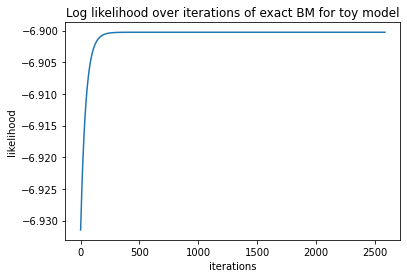

In [160]:
plt.plot([x for x in range(len(likelihoods))], likelihoods)
plt.xlabel("iterations")
plt.ylabel("likelihood")
plt.title("Log likelihood over iterations of exact BM for toy model")
plt.show()

## Salamander data

In [109]:
salamander = np.loadtxt('bint.txt')
for point in salamander:
    point[point == 0] = -1

In [112]:
# salamander = np.loadtxt('bint.txt')
# salamander = salamander.transpose()
print(salamander[:,:953].shape)

(160, 953)


In [115]:
train_salamander = salamander[:,:953]
part_indices = np.random.choice(range(160), size = 10, replace = False)
train_salamander_part = train_salamander[part_indices]
train_salamander_part = train_salamander_part.transpose()

In [116]:
print(train_salamander_part.shape)

(953, 10)


In [161]:
threshold_salamander = 1e-5
lr_salamander = 1e-3
mom_salamander = 0.01

w, theta, likelihoods = BM(train_salamander_part, lr_salamander, threshold_salamander, momentum = mom_salamander)

500
9.474756062979872e-05
1000
5.552083797934204e-05
1500
4.612106694799611e-05
2000
4.0444745347265056e-05
2500
3.623800385209735e-05
3000
3.2937884053450826e-05
3500
3.0288554661132838e-05
4000
2.8128120593284845e-05
4500
2.634065624562698e-05
5000
2.4840712952223232e-05
5500
2.3564804723651132e-05
6000
2.246543796595238e-05
6500
2.1506780356198714e-05
7000
2.0661541902160935e-05
7500
1.9908737802747794e-05
8000
1.9232078742703606e-05
8500
1.8618804089752874e-05
9000
1.805882844755913e-05
9500
1.7544111580638894e-05
10000
1.7068189093701926e-05
10500
1.6625819949618203e-05
11000
1.621271970963364e-05
11500
1.582535721206691e-05
12000
1.5460798571122377e-05
12500
1.511658672375578e-05
13000
1.4790647857914826e-05
13500
1.4481218292425323e-05
14000
1.4186787004851626e-05
14500
1.3906050197892706e-05
15000
1.3637875176492759e-05
15500
1.3381271462024891e-05
16000
1.3135367560832001e-05
16500
1.2899392173100489e-05
17000
1.2672658904652052e-05
17500
1.2454553757513392e-05
18000
1.2244524

In [123]:
from collections import Counter

Z_dep = partition(w, theta, all_states)

#observed rate deter
full_data = salamander[part_indices]
full_data = full_data.transpose()

full_data = full_data.tolist()
new_data = map(tuple, full_data)
new_data_set = [list(item) for item in set(tuple(row) for row in full_data)]

observed_occ = Counter(new_data)

observed_rate = []
for i in new_data_set:
    observed_rate.append(observed_occ[tuple(i)]/len(full_data))

approximated_rate = p(new_data_set, w, theta, Z_dep)

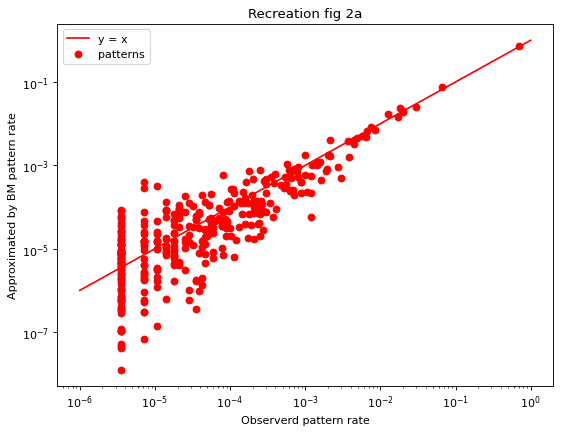

In [125]:
plt.figure(figsize = (8,6), dpi = 80)
plt.scatter(observed_rate, approximated_rate, label = "patterns", color = "red")      
plt.plot([x for x in np.linspace(0.000001,1, 10000)],[x for x in np.linspace(0.000001,1, 10000)], color = "red", label = "y = x")
plt.xlabel("Observerd pattern rate")
plt.ylabel("Approximated by BM pattern rate")
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.title("Recreation fig 2a")


# if platform == "linux" or platform == "linux2" or platform == "darwin":
#     plt.savefig("./PLOTS/BM_EXACT_SALAMANDER_" + str(threshold) + "_full.png")
# elif platform == "win32":
#     plt.savefig(".\\PLOTS\\BM_EXACT_SALAMANDER_" + str(threshold) + "_full.png")
plt.show()

#### Creating the indep model

In [177]:
w_indep, theta_indep, liks_indep = BM(train_salamander_part, lr_salamander * 10 **(1), threshold_salamander * 10**(2), mom_salamander, Energy_functional= E_indep)

Threshold verandering voor plotjes genereren.

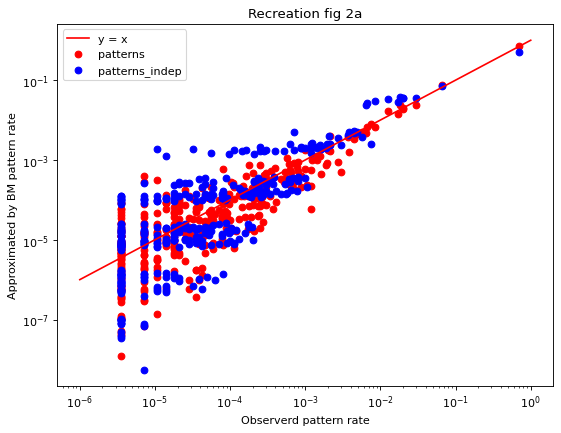

In [178]:
Z_indep = partition(w_indep, theta_indep, all_states, Energy_functional= E_indep)

approximated_rate_indep = p(new_data_set, w_indep, theta_indep, Z_indep, Energy_functional= E_indep)

plt.figure(figsize = (8,6), dpi = 80)
plt.scatter(observed_rate, approximated_rate, label = "patterns", color = "red")    
plt.scatter(observed_rate, approximated_rate_indep, label = "patterns_indep", color = "blue") 
plt.plot([x for x in np.linspace(0.000001,1, 10000)],[x for x in np.linspace(0.000001,1, 10000)], color = "red", label = "y = x")
plt.xlabel("Observerd pattern rate")
plt.ylabel("Approximated by BM pattern rate")
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.title("Recreation fig 2a")
plt.show()


## Metropolis Hastings Sampling

In [6]:
def E_difference(pattern, site, w, theta):
    return 2*pattern[site] * np.dot(w[site], pattern) + 2 * pattern[site] * theta[site]
    

In [7]:
def MH_sampler(w, theta, pattern, n_samples):    
    
    d = w.shape[0]
    
    # store the samples somewhere
    samples = np.zeros((n_samples, d))
    current_sample = pattern
    
    # get initial energy 
    energy = E(np.array([pattern]),w, theta)[0]
    
    # Precompute random numbers
    random_log = np.log(np.random.rand(n_samples))
    n_accept = 0
    for i in range(n_samples-1):
        de = E_difference(current_sample,i%d, w, theta)
        samples[i] = current_sample
        if de < 0 or -de > random_log[i]:
            current_sample[0,i%d] *=-1
            energy += de
            n_accept +=1

    
    samples[-1] = current_sample

    single = np.mean(samples, axis = 0)
    double = np.einsum('ki, kj -> ij', samples, samples)/len(samples)

    return single, double

array([[ 1., -1.,  0.],
       [-1.,  1.,  0.],
       [ 0.,  0.,  1.]])